In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from giems_lstm.config import Config
import os

os.chdir("..")

## Check Up & Preprocess

In [2]:
pred = xr.open_dataset("output/E_prediction.nc")
pred

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 492, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1984-01-01 1984-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    fwet     (time, lat, lon) float32 2GB ...

In [3]:
config = Config("config/E.toml", "analyze")
TVARs = config.TVARs
TVARs.keys()

dict_keys(['giems2', 'era5', 'mswep', 'gleam', 'grace'])

In [4]:
train_years = config.train.train_years
train_years

[1992,
 1993,
 1994,
 2003,
 2004,
 2005,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2018,
 2019]

In [5]:
mask = config.mask
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [6]:
pixel_area = xr.open_dataset("data/clean/PixelArea_area.nc")
pixel_area

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    area     (lat, lon) float64 8MB ...

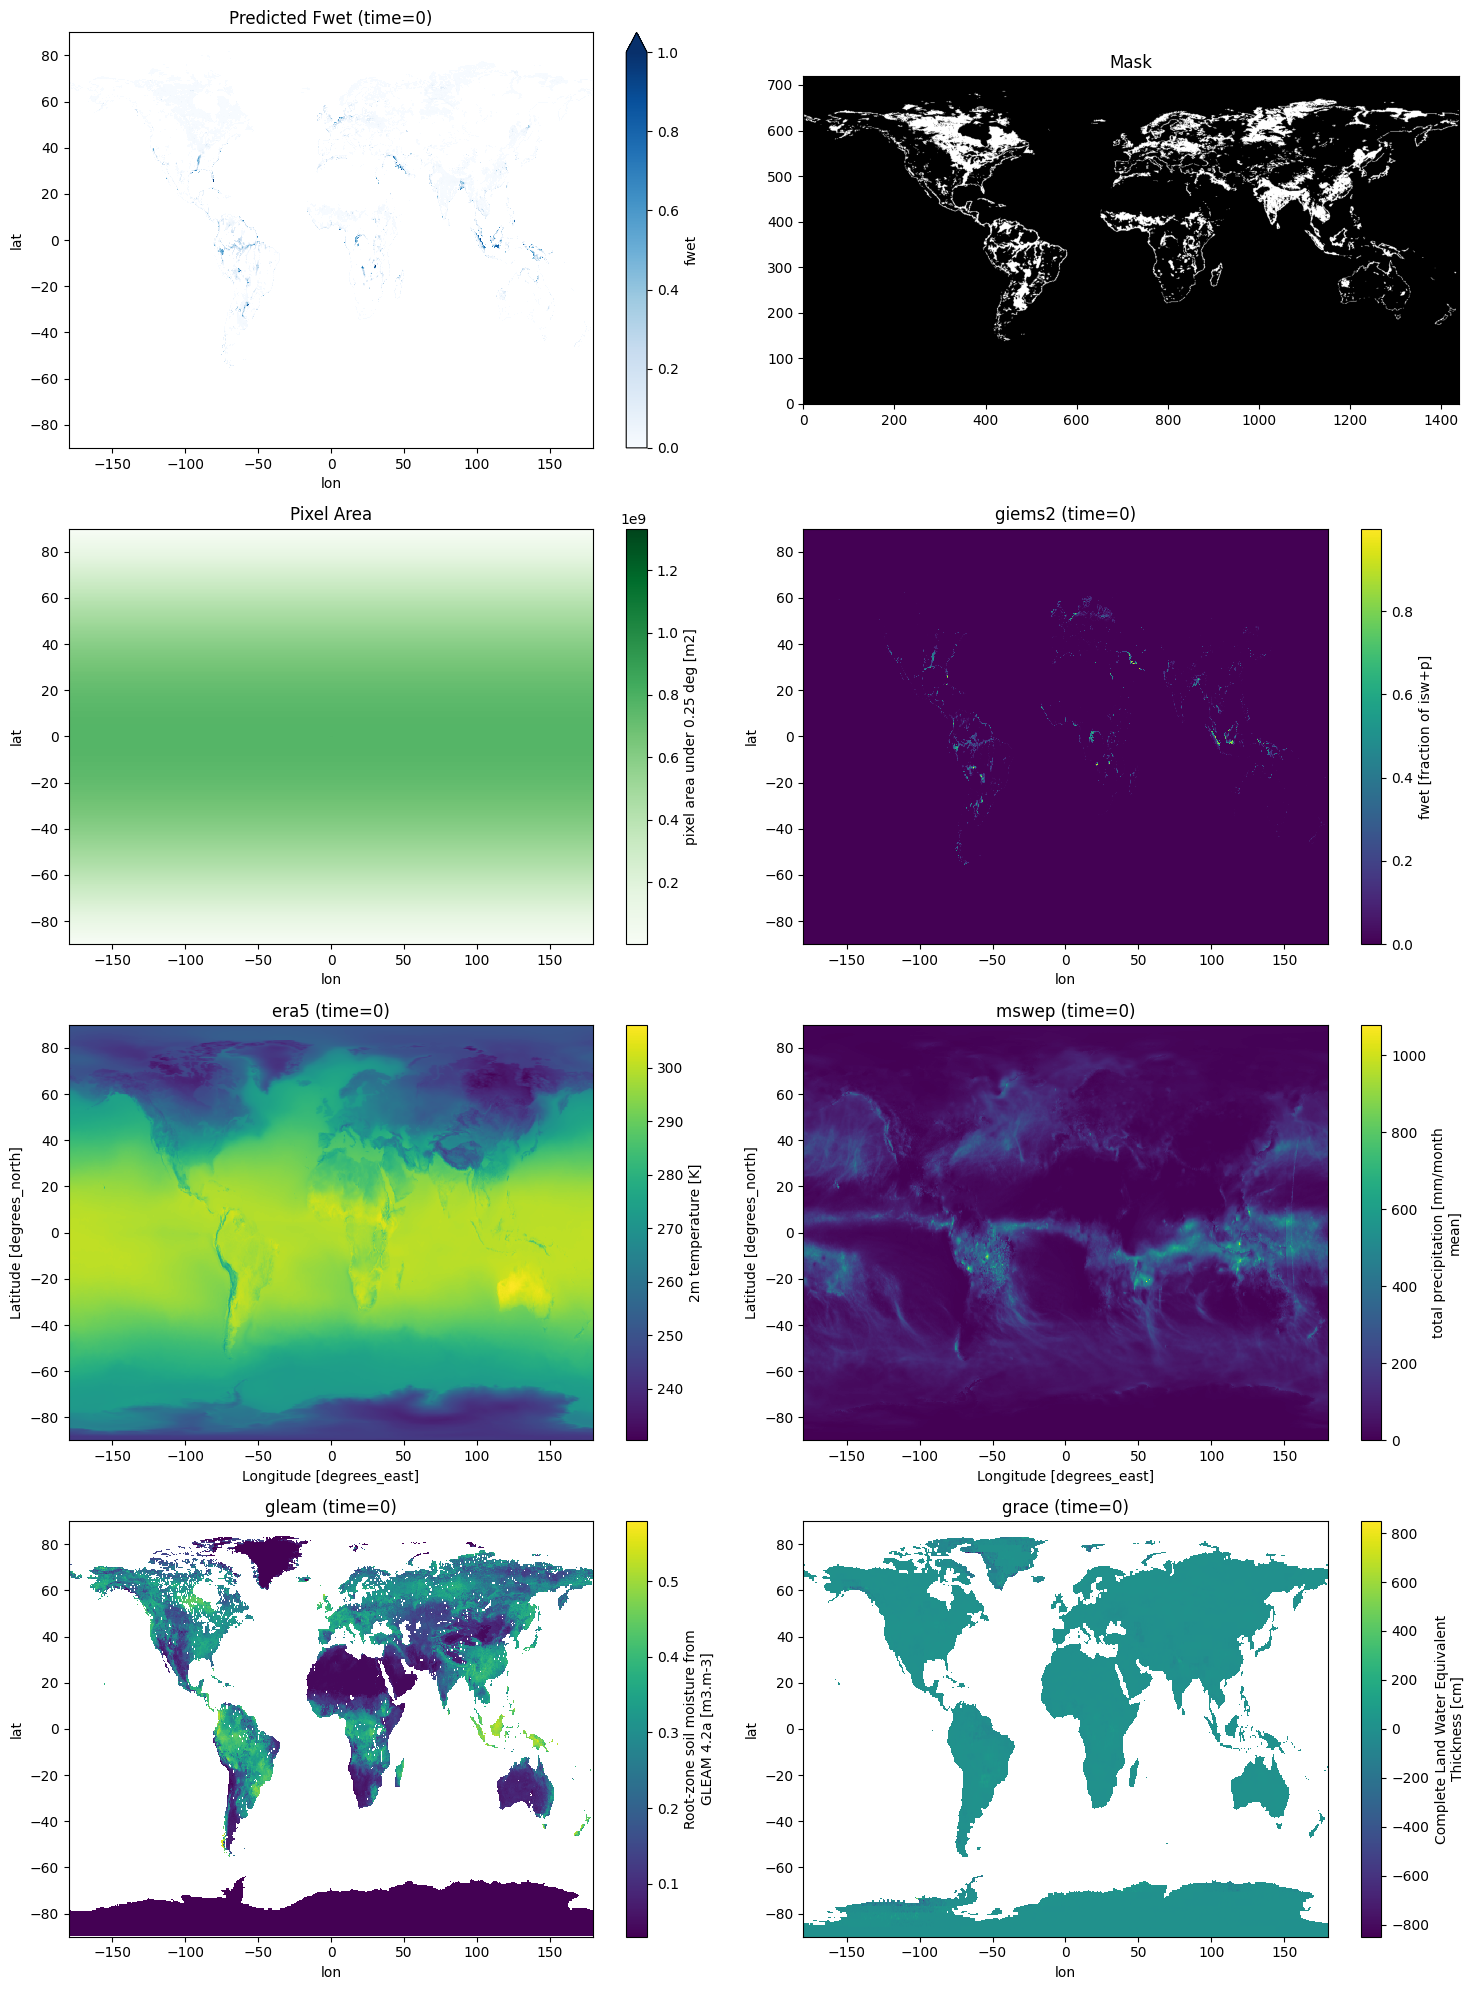

In [8]:
# Overall view
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

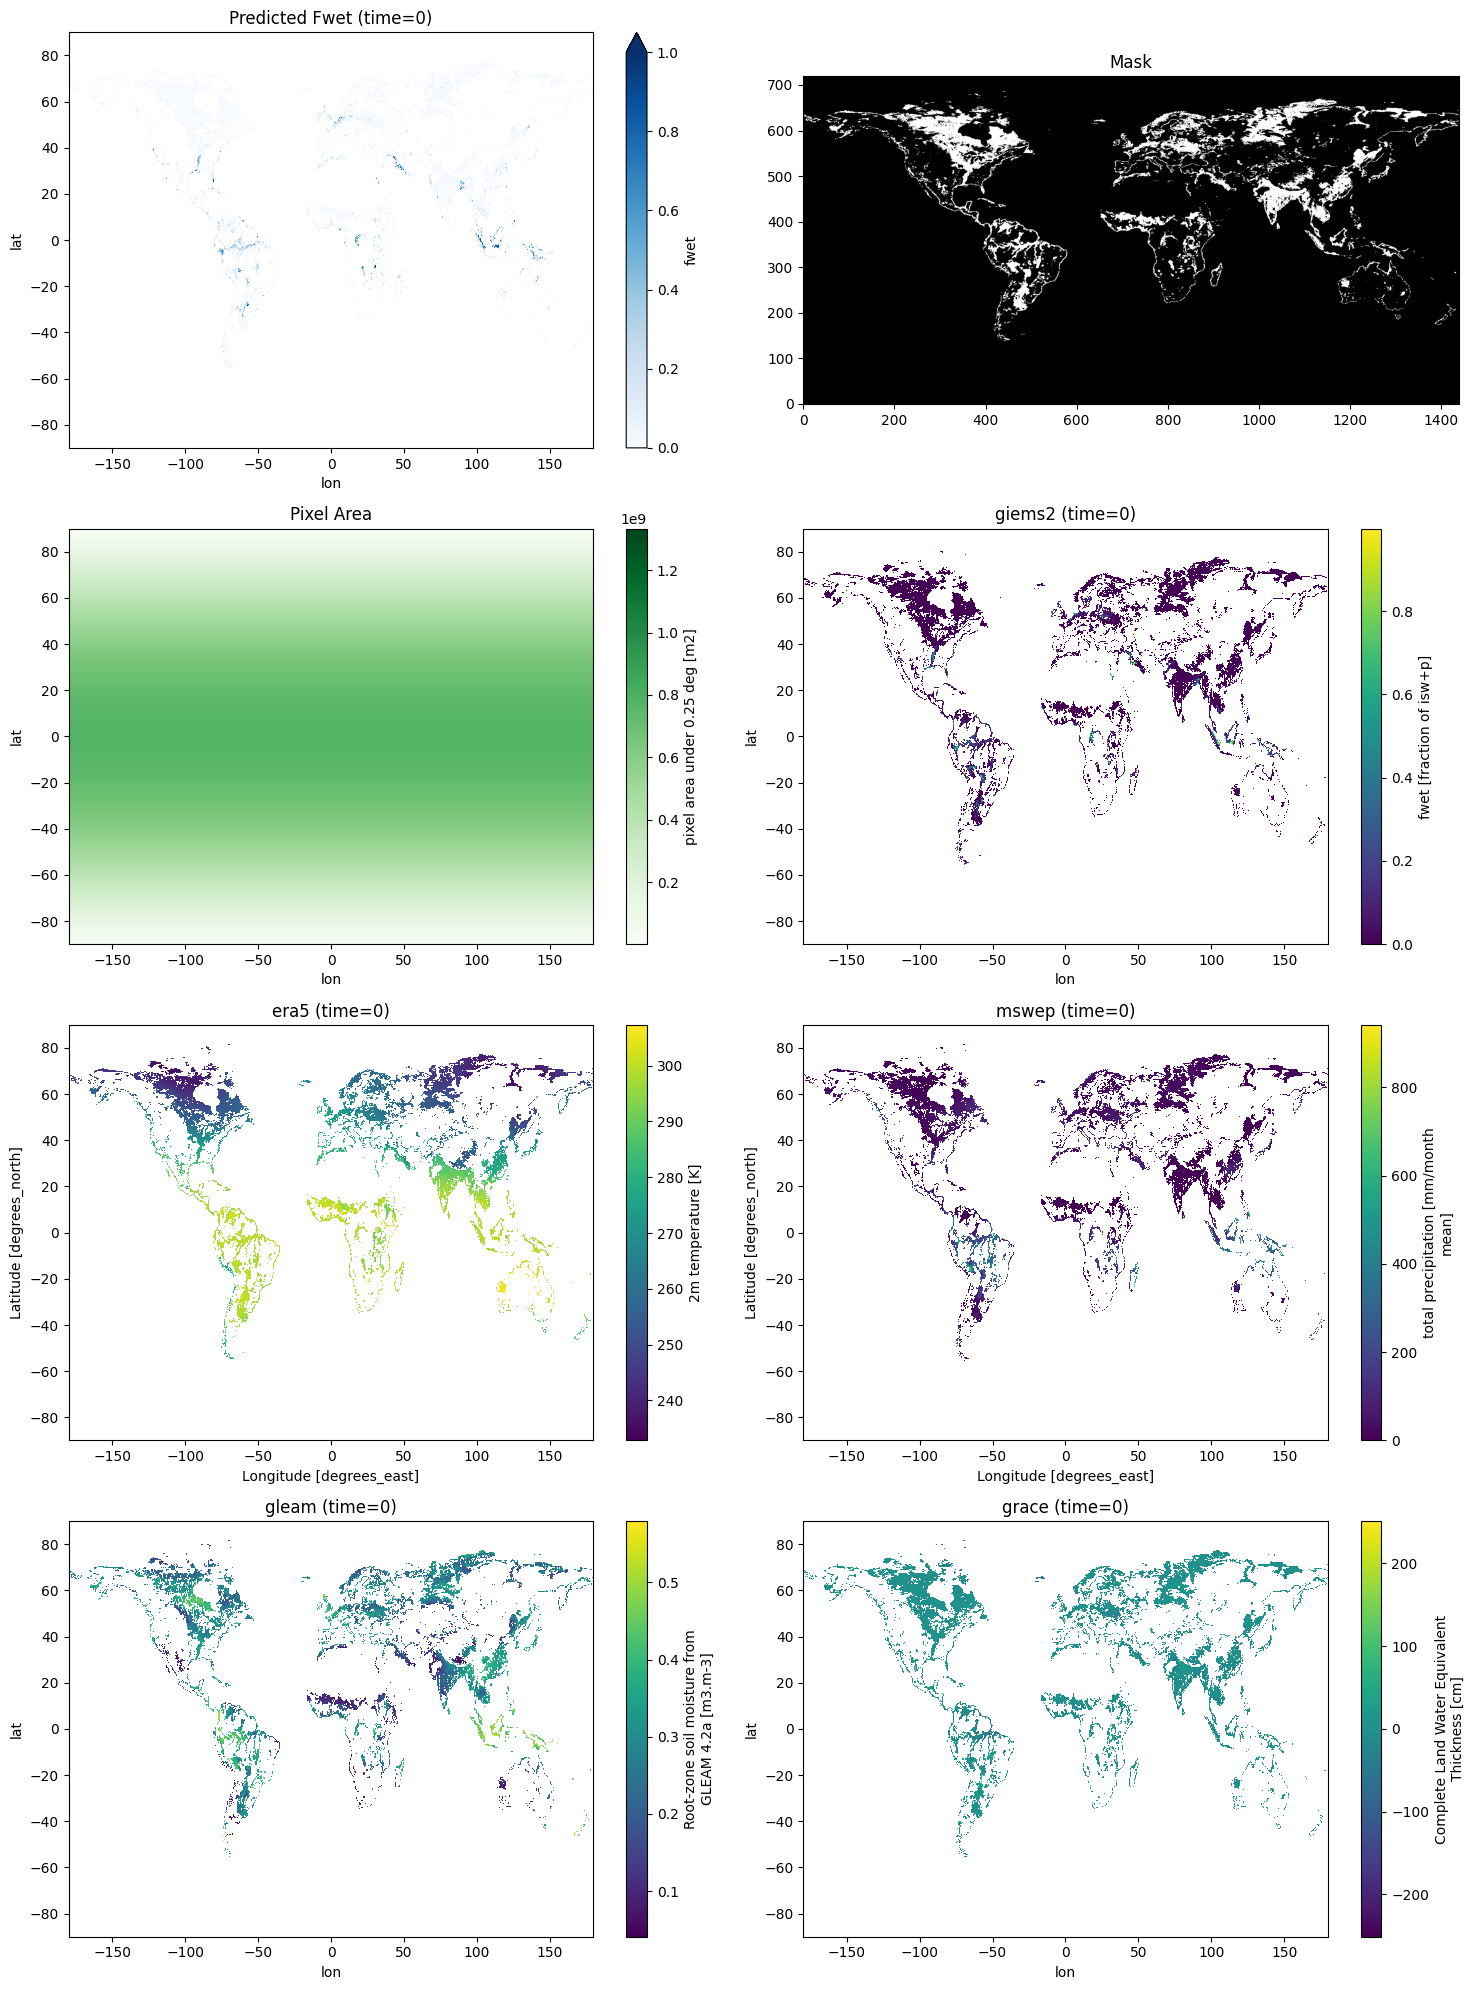

In [9]:
# all the data need to be masked
for var in TVARs.keys():
    TVARs[var] = TVARs[var].where(mask)

pred = pred.transpose("time", "lat", "lon")
pred["fwet"] = pred["fwet"].where(mask)

# check again
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

In [11]:
# apply weights
pred_area = pred["fwet"] * pixel_area["area"]
giems_area = TVARs["giems2"] * pixel_area["area"]

weight = np.nanmax(TVARs["giems2"].values, axis=0)
grace_weighted = TVARs["grace"] * weight
mswep_weighted = TVARs["mswep"] * weight
gleam_weighted = TVARs["gleam"] * weight

C:\Users\FireFighter\AppData\Local\Temp\ipykernel_23408\70453930.py:5: RuntimeWarning: All-NaN slice encountered
  weight = np.nanmax(TVARs["giems2"].values, axis=0)


## Global

In [12]:
def compute_GY(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="YS").mean()


pred_area_GY = compute_GY(pred_area)
giems_area_GY = compute_GY(giems_area)
grace_weighted_GY = compute_GY(grace_weighted)
mswep_weighted_GY = compute_GY(mswep_weighted)
gleam_weighted_GY = compute_GY(gleam_weighted)

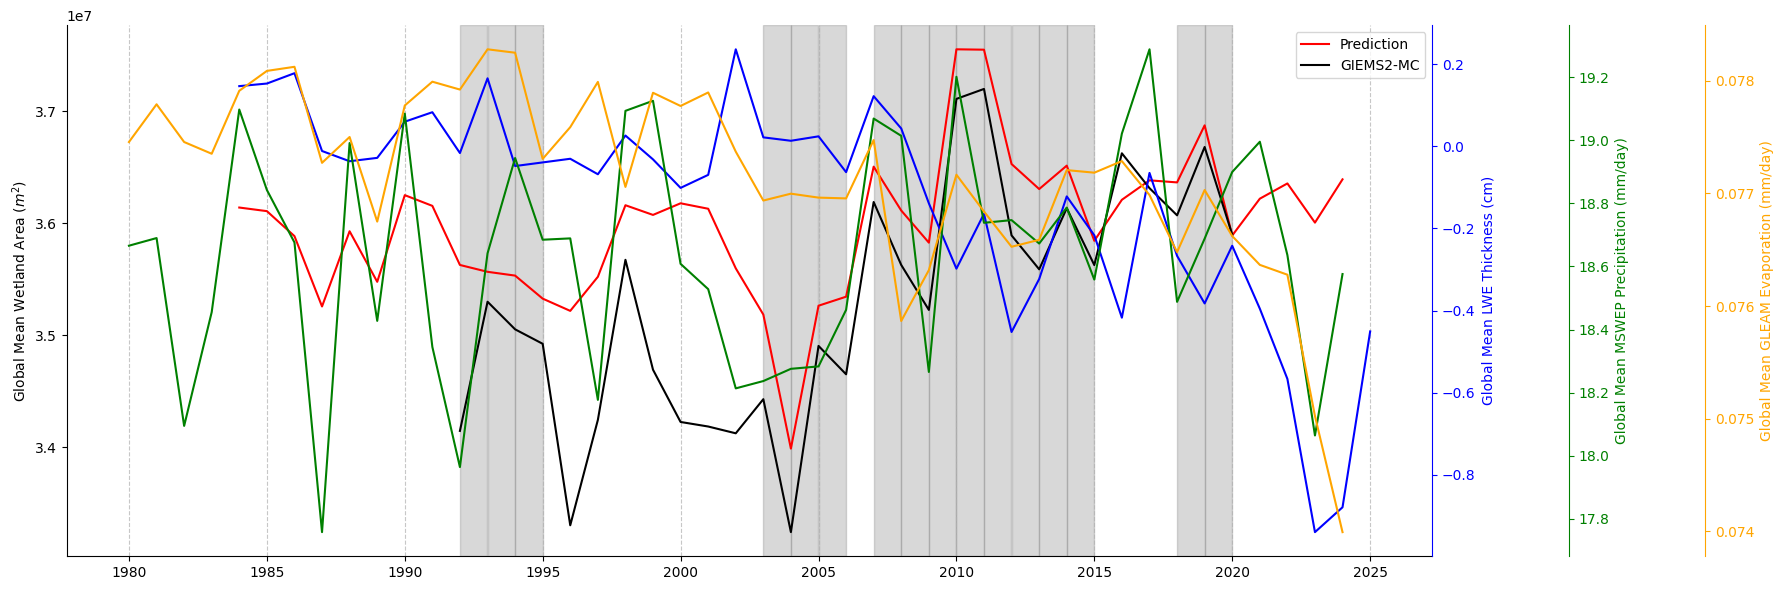

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred_area_GY.time,
    pred_area_GY,
    label="Prediction",
    color="red",
)
ax.plot(
    giems_area_GY.time,
    giems_area_GY,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel("Global Mean Wetland Area ($m^2$)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


def draw_compare(dataarray, offset, label, color):
    bx = ax.twinx()
    bx.plot(
        dataarray.time,
        dataarray,
        color=color,
    )
    bx.spines["right"].set_position(("axes", offset))
    bx.spines["right"].set_color(color)
    bx.spines["left"].set_visible(False)
    bx.spines["top"].set_visible(False)
    bx.spines["bottom"].set_visible(False)
    bx.grid(False)
    bx.set_ylabel(label, color=color)
    bx.yaxis.label.set_color(color)
    bx.tick_params(axis="y", colors=color)


draw_compare(grace_weighted_GY, 1, "Global Mean LWE Thickness (cm)", "blue")
draw_compare(
    mswep_weighted_GY, 1.1, "Global Mean MSWEP Precipitation (mm/day)", "green"
)
draw_compare(gleam_weighted_GY, 1.2, "Global Mean GLEAM Evaporation (mm/day)", "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

fig.tight_layout()

In [14]:
# Let's see global monthly
def compute_GM(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="MS").mean()


pred_area_GM, giems_area_GM, grace_weighted_GM, mswep_weighted_GM, gleam_weighted_GM = (
    map(
        compute_GM,
        [
            pred_area,
            giems_area,
            grace_weighted,
            mswep_weighted,
            gleam_weighted,
        ],
    )
)

In [ ]:
"""Template for plotting
pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()

draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()
"""

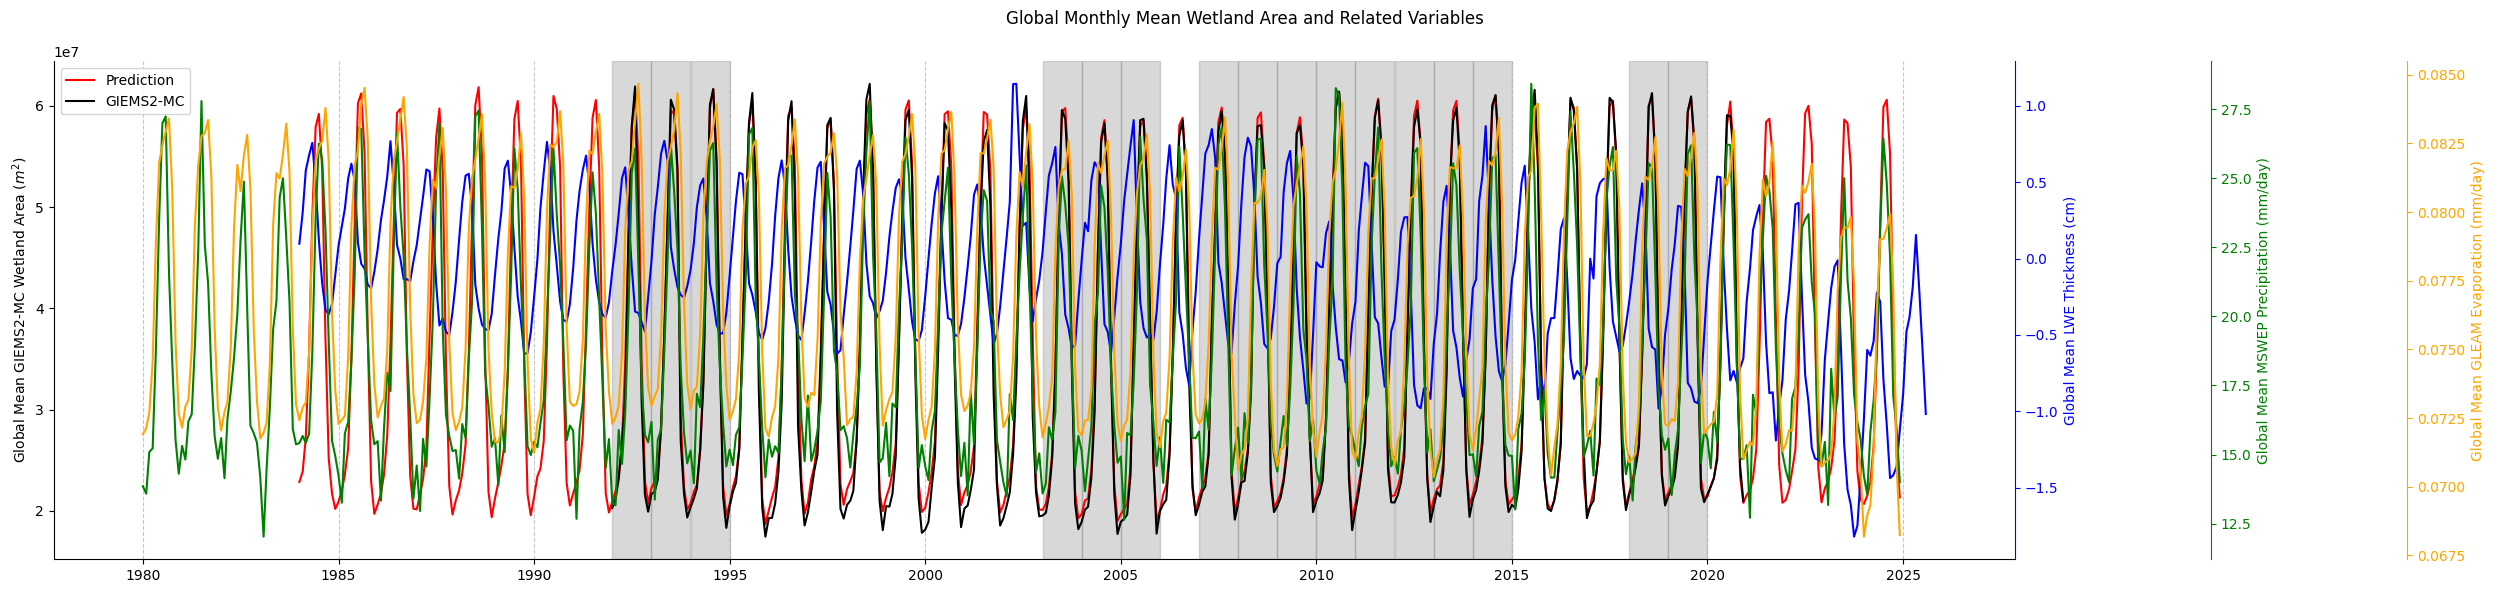

In [15]:
datas = (
    pred_area_GM,
    giems_area_GM,
    grace_weighted_GM,
    mswep_weighted_GM,
    gleam_weighted_GM,
)
title = "Global Monthly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Global Mean Predicted Wetland Area ($m^2$)",
    "giems": "Global Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Global Mean LWE Thickness (cm)",
    "mswep": "Global Mean MSWEP Precipitation (mm/day)",
    "gleam": "Global Mean GLEAM Evaporation (mm/day)",
}


pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()

draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")
# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

## Tropical

lat : -30 to 30

In [16]:
def compute_TY(dataarray: xr.DataArray):
    return (
        dataarray.sel(lat=slice(-30, 30))
        .mean(dim=["lat", "lon"], skipna=True)
        .resample(time="YS")
        .mean()
    )


datas = (
    compute_TY(pred_area),
    compute_TY(giems_area),
    compute_TY(grace_weighted),
    compute_TY(mswep_weighted),
    compute_TY(gleam_weighted),
)

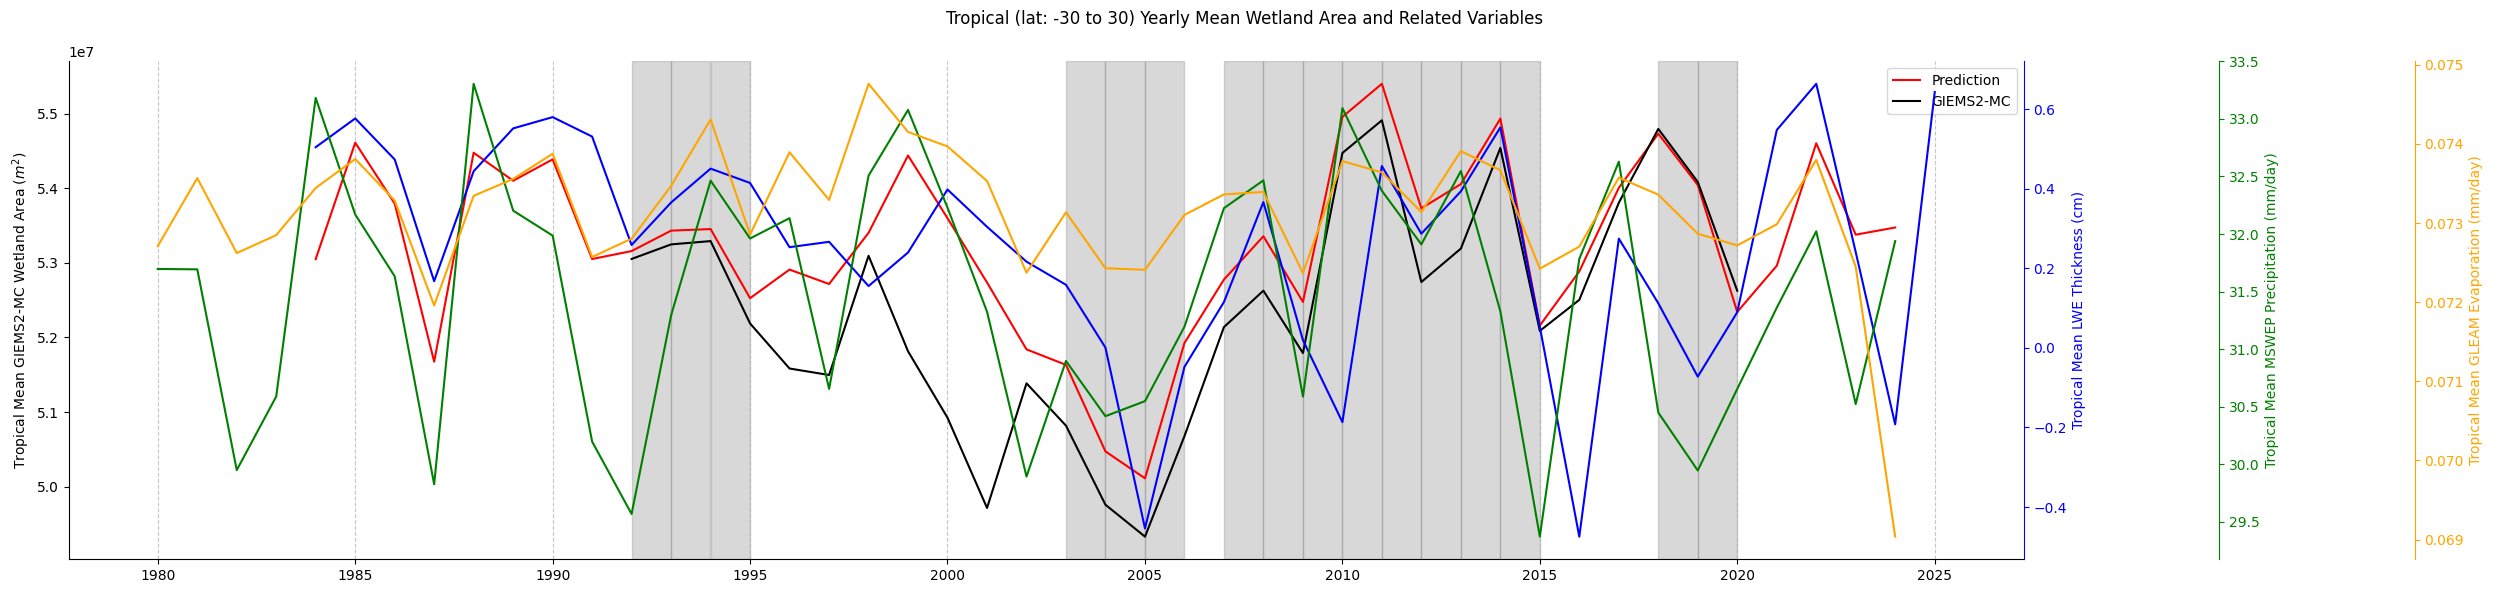

In [17]:
title = "Tropical (lat: -30 to 30) Yearly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Tropical Mean Predicted Wetland Area ($m^2$)",
    "giems": "Tropical Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Tropical Mean LWE Thickness (cm)",
    "mswep": "Tropical Mean MSWEP Precipitation (mm/day)",
    "gleam": "Tropical Mean GLEAM Evaporation (mm/day)",
}

pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

In [18]:
# Tropical Monthly
def compute_TM(dataarray: xr.DataArray):
    return (
        dataarray.sel(lat=slice(-30, 30))
        .mean(dim=["lat", "lon"], skipna=True)
        .resample(time="MS")
        .mean()
    )


datas = (
    compute_TM(pred_area),
    compute_TM(giems_area),
    compute_TM(grace_weighted),
    compute_TM(mswep_weighted),
    compute_TM(gleam_weighted),
)

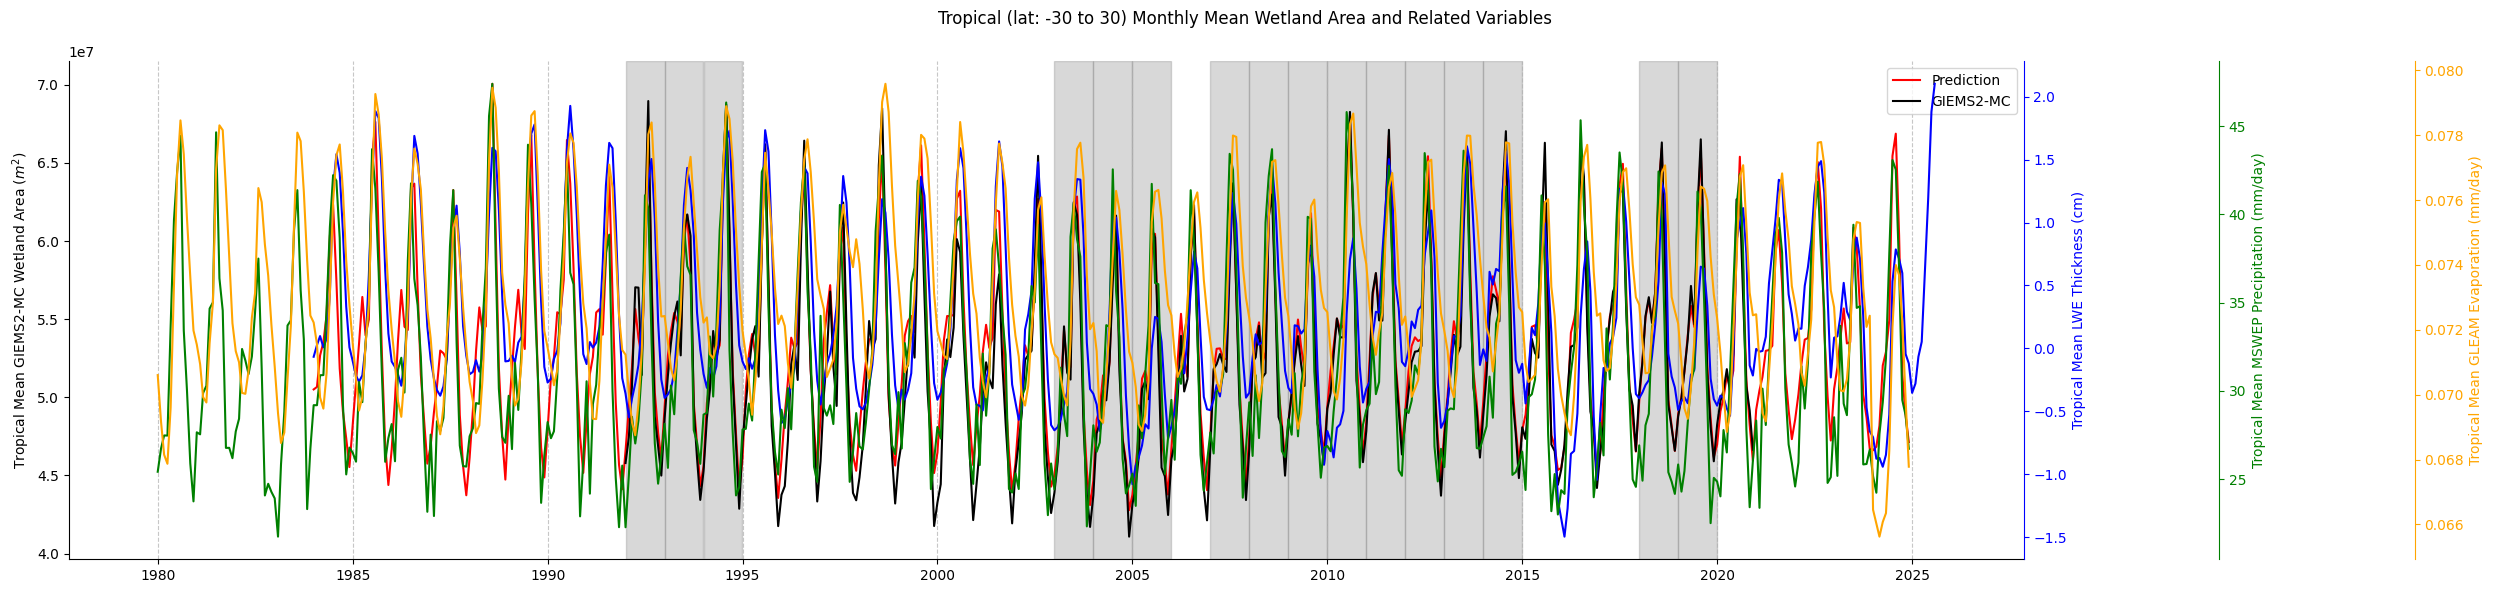

In [19]:
title = "Tropical (lat: -30 to 30) Monthly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Tropical Mean Predicted Wetland Area ($m^2$)",
    "giems": "Tropical Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Tropical Mean LWE Thickness (cm)",
    "mswep": "Tropical Mean MSWEP Precipitation (mm/day)",
    "gleam": "Tropical Mean GLEAM Evaporation (mm/day)",
}

pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

## RMSE of Global Mean Time Series

In [20]:
time = giems.time
pred_selected = pred_area.sel(time=time)
pred_selected

<xarray.DataArray (time: 348, lat: 720, lon: 1440)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2

In [21]:
# Calculate RMSE on each grid cell
rmse_grid = np.sqrt(((pred_selected - giems_area) ** 2).mean(dim="time", skipna=True))
rmse_grid

<xarray.DataArray (lat: 720, lon: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

Text(0.5, 1.0, 'RMSE of Predicted Wetland Area ($m^2$)')

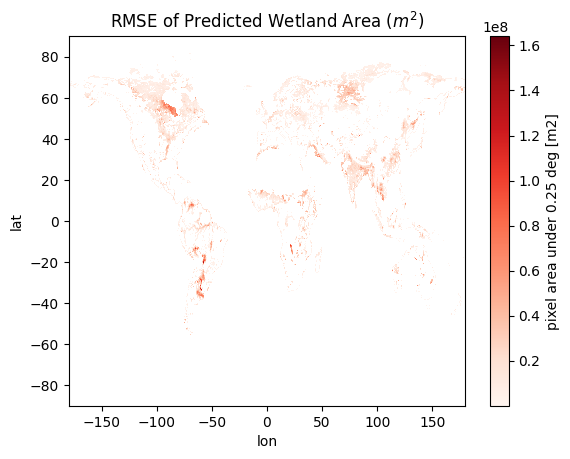

In [22]:
rmse_grid.plot(cmap="Reds")
plt.title("RMSE of Predicted Wetland Area ($m^2$)")

In [23]:
rmse_time = np.sqrt(
    ((pred_selected - giems_area) ** 2).mean(dim=["lat", "lon"], skipna=True)
)
rmse_time

<xarray.DataArray (time: 348)> Size: 3kB
array([19696190.68552591, 21237789.77726957, 21434036.03204671,
       21374787.88531189, 35874203.45480994, 28095777.01661028,
       29735764.74360131, 26002395.55967717, 35461151.90573215,
       35474624.32740243, 22199747.33902485,  8783282.46618518,
        9855125.50671683, 12652525.29754284, 11309019.79344937,
       12671088.05144175, 14771245.05353958, 18626961.80218562,
       13798011.27203194, 15071684.35873003, 15291403.90502103,
       16114287.35847672, 10605982.83617034,  7659188.17378011,
        9392275.00838033,  9383428.65688104,  9718928.03829831,
       11027612.56445421, 14607921.53783934, 14483930.97087706,
       15124160.97046009, 15761681.30124916, 13097384.29745588,
       13130940.30501235,  8916886.64499893,  6953435.18415207,
       16983795.941864  , 18657204.99042674, 19379118.93063871,
       21705548.48817621, 34992020.35592148, 21370856.16523963,
       21793057.92634529, 22574340.25030811, 23751439.27737038,
       39524685.57778781, 20375655.20961337, 15954469.61531551,
       17755055.84006007, 21516573.06350551, 19585506.24824207,
       21471900.53742065, 34973389.87492458, 27769623.19175942,
       23019862.00411771, 23242809.401122  , 29288798.30745005,
       34240717.37760314, 20701813.00924006, 17106290.90815688,
...
       18158962.49025328, 19827522.84406696, 19798059.594401  ,
       21607697.81181058, 32292414.3323051 , 22994427.66480006,
       22389819.11077934, 20689997.62614523, 21988783.55726966,
       35365512.10834903, 30748818.01483576, 15147964.16784048,
       16161387.96778795, 17506962.1687715 , 17739991.35460832,
       22068116.67832789, 33625822.77277517, 26926522.24528657,
       22244730.69205473, 21340184.1969273 , 21002241.72691728,
       34045868.21709873, 19771182.10515919, 13861682.11472559,
       10182061.70306863,  9491406.05964041, 10096052.73470965,
       10665848.9561341 , 11566538.13071388, 11103118.61365409,
       11233096.34845617, 11788968.11875387, 10929700.55091454,
       10418811.44204782,  9435210.38360358,  8296937.52785789,
        8685946.88753902, 12177419.25242022,  8891559.22988814,
        9641436.33642983, 15909923.9528501 , 10486967.34192361,
       10339657.57193791, 11737104.80431067, 10207816.15257077,
       10982931.68239046,  7525889.97882975,  9503702.87168901,
       16666284.67913091, 21455774.7542871 , 17800985.92972159,
       19471712.607578  , 39719672.25075589, 23857592.63411159,
       21387619.03963426, 21592246.56064879, 21612917.01876371,
       33482162.83907534, 22975484.74633205, 17116908.55784776])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

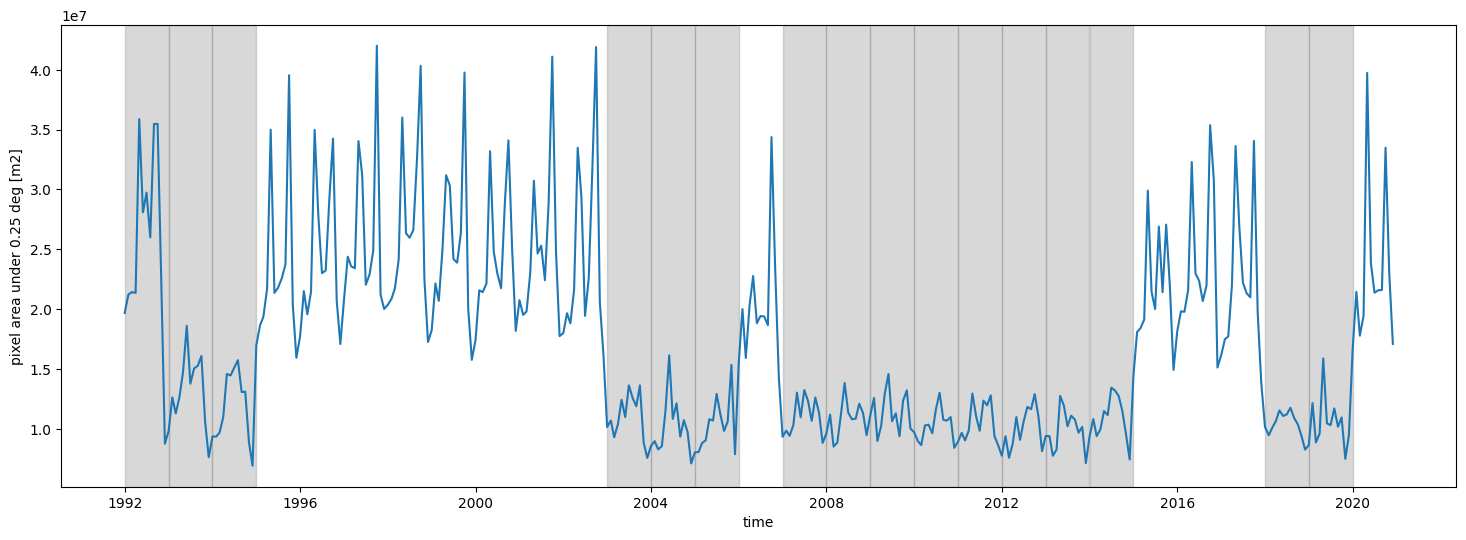

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))
rmse_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

In [25]:
# sMAPE = 2 * |F - A| / (|F| + |A|)
smape = (
    2
    * np.abs(pred_selected - giems_area)
    / (np.abs(pred_selected) + np.abs(giems_area))
)
smape_time = smape.mean(dim=["lat", "lon"], skipna=True)
smape_time

<xarray.DataArray (time: 348)> Size: 3kB
array([1.49426401, 1.50719511, 1.46607248, 1.38962669, 1.25400315,
       0.9543388 , 0.66244733, 0.55484926, 0.85274139, 1.26216562,
       1.44325181, 1.45513414, 1.47672582, 1.4920511 , 1.46901456,
       1.32561124, 1.12645261, 0.85476928, 0.51688051, 0.53366704,
       0.68531875, 1.23183135, 1.39437079, 1.47169476, 1.47177708,
       1.48719772, 1.46880271, 1.36109056, 1.17175746, 0.85394144,
       0.5119213 , 0.4931726 , 0.65342532, 1.07307709, 1.37213735,
       1.46002953, 1.5064698 , 1.49217584, 1.47291972, 1.39188049,
       1.19208491, 0.87655678, 0.58713878, 0.54933137, 0.75284186,
       1.16830387, 1.45124755, 1.52965276, 1.52611076, 1.53631787,
       1.51489166, 1.45862895, 1.25189148, 0.92016568, 0.60841049,
       0.55269667, 0.75106451, 1.23932363, 1.41623169, 1.51814844,
       1.53046332, 1.50535335, 1.47159908, 1.41472838, 1.20550271,
       0.91681987, 0.58298839, 0.56245708, 0.71773138, 1.24106775,
       1.43956557, 1.49426176, 1.49582543, 1.49049927, 1.48864059,
       1.38768244, 1.19155333, 0.87103355, 0.57325558, 0.54081514,
       0.75157513, 1.19694584, 1.46620774, 1.52810913, 1.51126253,
       1.531209  , 1.50509892, 1.40924992, 1.19998933, 0.93055754,
       0.584197  , 0.55048228, 0.73434217, 1.19905932, 1.4507917 ,
       1.51980292, 1.54723242, 1.5319335 , 1.4787448 , 1.39198901,
...
       1.32609605, 1.48632966, 1.4915049 , 1.47880447, 1.47630637,
       1.40916421, 1.12776095, 0.72872944, 0.50096761, 0.47257191,
       0.56084046, 0.96148448, 1.30355057, 1.45555282, 1.46566326,
       1.46009533, 1.40386995, 1.30773114, 1.11400062, 0.74300954,
       0.5036523 , 0.46638142, 0.56424896, 1.05097884, 1.33106513,
       1.4262405 , 1.47839914, 1.48400031, 1.44251008, 1.35608513,
       1.15263564, 0.84145218, 0.551036  , 0.51943122, 0.61379235,
       1.13263727, 1.36868867, 1.4434685 , 1.50149658, 1.47781624,
       1.43971946, 1.35017257, 1.113795  , 0.81618658, 0.52367568,
       0.50830562, 0.6317484 , 1.12853312, 1.40290425, 1.48914604,
       1.50201125, 1.48864339, 1.43636514, 1.36060563, 1.17230431,
       0.87052131, 0.54251463, 0.50342648, 0.60157866, 1.12442534,
       1.37178097, 1.4609246 , 1.44123092, 1.45368268, 1.44402809,
       1.3656301 , 1.11679636, 0.87080968, 0.49557159, 0.46820055,
       0.57197521, 1.00249413, 1.31379226, 1.43660194, 1.45400891,
       1.4449839 , 1.39982104, 1.30466505, 1.07869324, 0.75626522,
       0.47914378, 0.45868744, 0.53411744, 0.97717443, 1.3315665 ,
       1.39360711, 1.44273155, 1.45021665, 1.41604208, 1.3511796 ,
       1.18972462, 0.86436659, 0.54336368, 0.51541465, 0.59119009,
       1.13712146, 1.355073  , 1.43380807])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

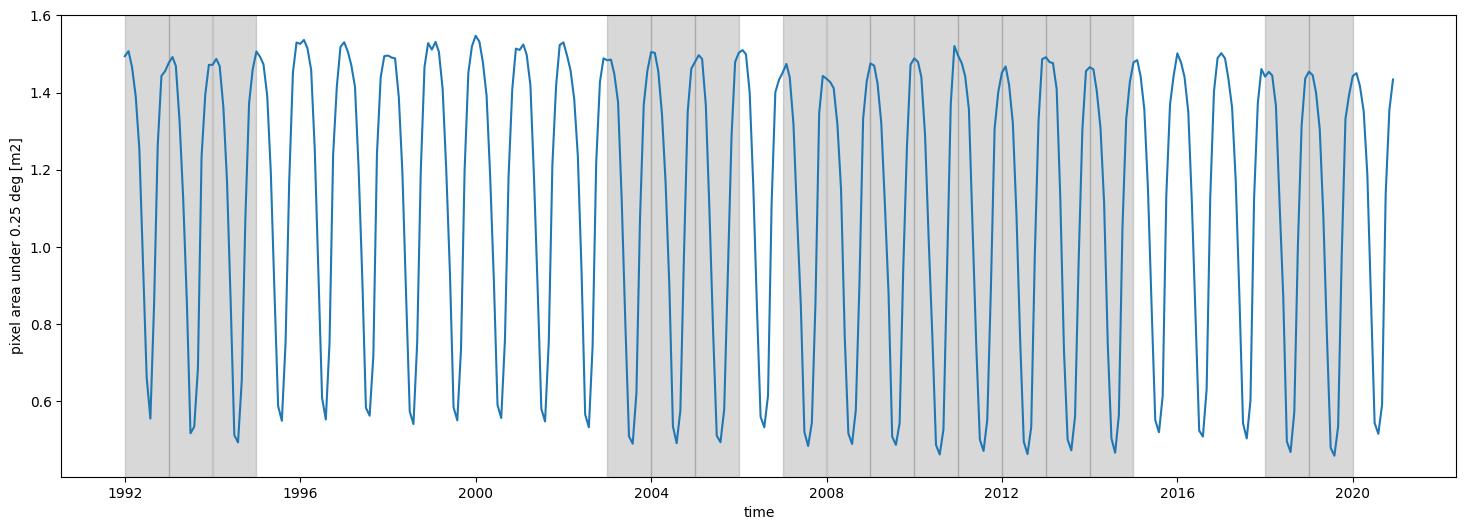

In [26]:
fig, ax = plt.subplots(figsize=(18, 6))
smape_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

In [27]:
# Accuracy = 1 - |F - A| / A
accuracy = 1 - np.divide(
    np.abs(pred_selected - giems_area),
    giems_area,
    out=np.zeros_like(pred_selected),
    where=giems_area != 0,
)
accuracy_time = accuracy.mean(dim=["lat", "lon"], skipna=True)
accuracy_grid = accuracy.mean(dim="time", skipna=True)

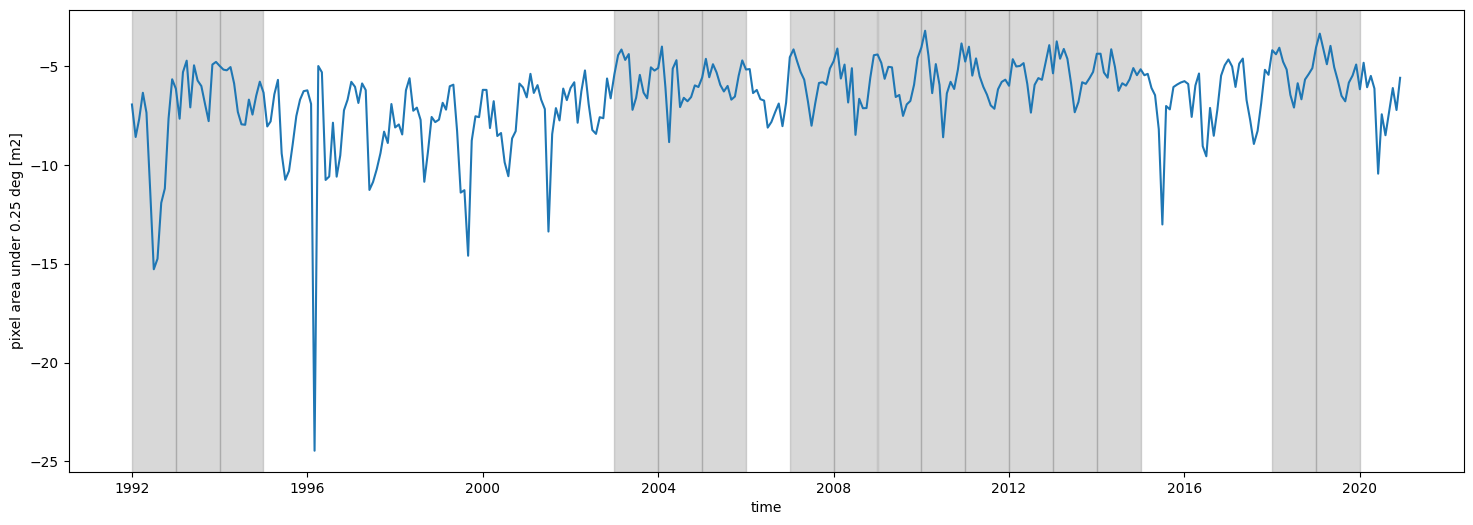

In [28]:
fig, ax = plt.subplots(figsize=(18, 6))
accuracy_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

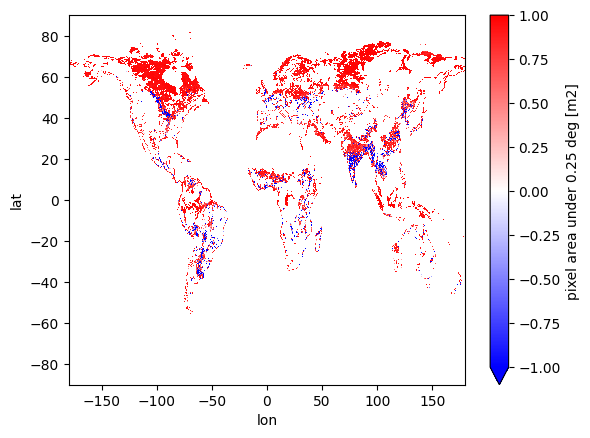

In [29]:
accuracy_grid.plot(vmax=1, vmin=-1, cmap="bwr")